In [1]:
# pip install geoaugment==0.1.3

In [2]:
import geo_augment

print("GeoAugment version loaded successfully")

GeoAugment version loaded successfully


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# GeoAugment core
from geo_augment.domains.floods.features import stack_flood_features
from geo_augment.io.raster import RasterLoader
from geo_augment.domains.floods.api import synthesize_flood_risk

# Evaluation utilities
from geo_augment.domains.floods.spec import (
    DEFAULT_FLOOD_SPEC,
    DEFAULT_FLOOD_CONSTRAINTS,
    DEFAULT_LATENT_SPEC,
)

# Optional post-processing
from geo_augment.domains.floods.threshold import apply_percentile_threshold

# Dataset utilities
from geo_augment.datasets.tiling import tile_raster

from geo_augment.evaluation.floods import flooded_area_ratio
from geo_augment.evaluation.floods import (
    distribution_summary,
    spatial_correlation,
)

In [4]:
# Load Nigeria DEM

dem = RasterLoader('nigeria.tif').read()

dem.shape, dem.min(), dem.max()

((3601, 3601), np.int16(-34), np.int16(55))

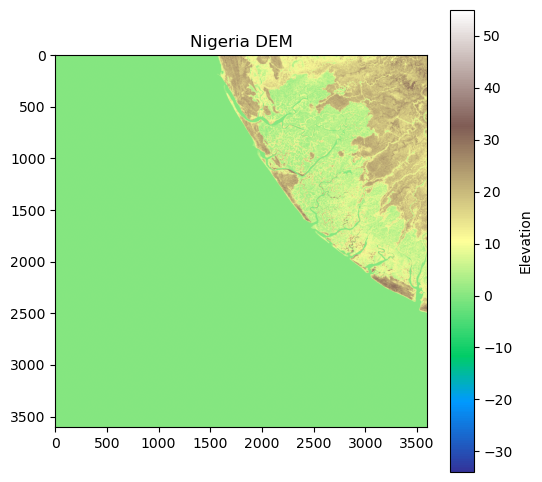

In [5]:
# Visualize DEM
plt.figure(figsize=(6, 6))
plt.imshow(dem, cmap="terrain")
plt.colorbar(label="Elevation")
plt.title("Nigeria DEM")
plt.show()

In [6]:
# Extract Flood-Relevant Features

features = stack_flood_features(dem)

features.shape

(4, 3601, 3601)

## Generate Continuous Flood Risk

GeoAugment generates **continuous flood risk values in [0, 1]**.

Interpretation:
- 0.0 → negligible flood susceptibility
- 1.0 → extreme flood susceptibility

This is **not a flood prediction**, but a **plausible risk surface**.


In [7]:
# Generate Flood Risk

risk_maps = synthesize_flood_risk(
    dem=dem,
    synthesis_spec=DEFAULT_FLOOD_SPEC,
    constraints=DEFAULT_FLOOD_CONSTRAINTS,
    latent_spec=DEFAULT_LATENT_SPEC,
    n_samples=1,
)

risk = risk_maps[0]

print("Risk range:", risk.min(), risk.max())

Risk range: 0.4528358407724481 0.9999999900000002


### GeoAugment converts raw DEMs into physically meaningful features.

These typically include:

Elevation

Slope

Flow accumulation

Base flood susceptibility

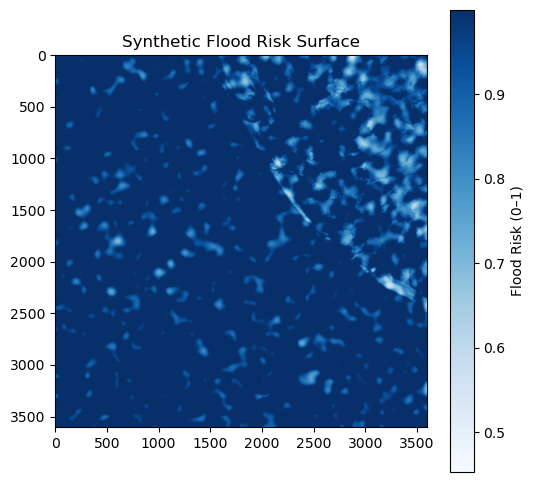

In [8]:
# Visualize flood risk
plt.figure(figsize=(6, 6))
plt.imshow(risk, cmap="Blues")
plt.colorbar(label="Flood Risk (0–1)")
plt.title("Synthetic Flood Risk Surface")
plt.show()

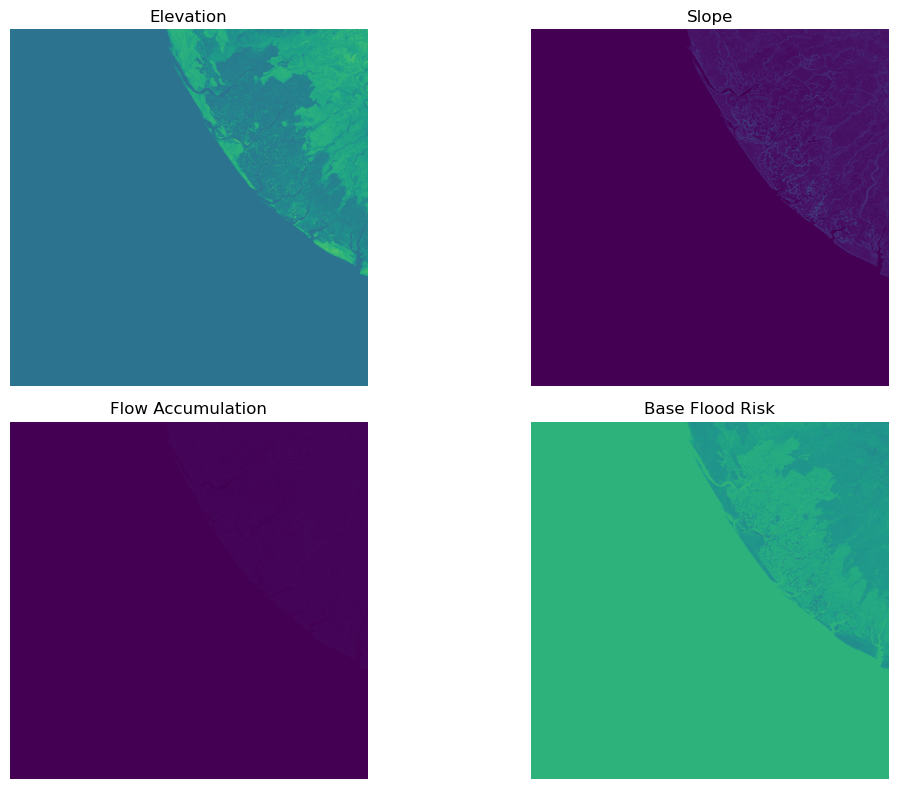

In [9]:
# Inspect features

feature_names = [
    "Elevation",
    "Slope",
    "Flow Accumulation",
    "Base Flood Risk"
]

plt.figure(figsize=(12, 8))

for i, name in enumerate(feature_names):
    plt.subplot(2, 2, i + 1)
    plt.imshow(features[i], cmap="viridis")
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Distribution Summary - Evaluation

summary = distribution_summary(risk)
summary

{'mean': 0.9779923232545866,
 'std': 0.0522513314905236,
 'min': 0.4528358407724481,
 'max': 0.9999999900000002,
 'p10': 0.9129558655752006,
 'p50': 0.9999999900000002,
 'p90': 0.9999999900000002}

In [11]:
# Spatial Correlation
corr = spatial_correlation(risk)
print("Spatial correlation:", corr)

Spatial correlation: 0.9984285360580715


In [12]:
# Flooded Area Ratio
area_ratio = flooded_area_ratio(risk, threshold=0.75)
print("High-risk area ratio:", area_ratio)

High-risk area ratio: 0.9908897070385506


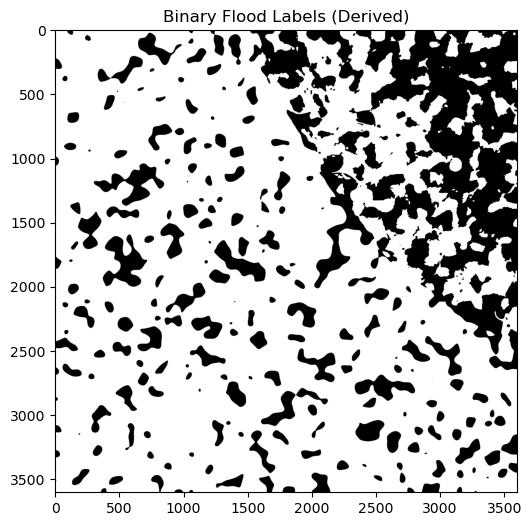

In [13]:
# Binary labels
binary_labels = apply_percentile_threshold(
    risk,
    percentile=90,
)

plt.figure(figsize=(6, 6))
plt.imshow(binary_labels, cmap="gray")
plt.title("Binary Flood Labels (Derived)")
plt.show()

## Typical values:

> 0.6 → strong spatial agreement

> < 0.3 → overly distorted (investigate)

In [14]:
# Tile Dataset for ML / DL Training
# Example: stack risk as a single-channel feature
features = np.expand_dims(risk, axis=0)

X, y = tile_raster(
    features=features,
    labels=binary_labels,
    tile_size=256,
    overlap=64,
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (324, 1, 256, 256)
y shape: (324, 256, 256)


In [15]:
# Export Dataset (Optional)

from geo_augment.datasets.export import export_npz

export_npz(
    X,
    y,
    out_dir="geoaugment_output",
    name="nigeria_flood_tiles"
)

## Key Takeaways

- Flood risk is **continuous by design**
- Binary labels are optional
- Evaluation is about **plausibility**, not accuracy
- Works with any ML framework

You can now train models using:

PyTorch

TensorFlow

scikit-learn